# Week 1 Seminar

A/B experiment analysis

In [315]:
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

%matplotlib inline

In [316]:
experiment = "CONTEXTUAL_COMP_FINAL"

In [317]:
data = pd.read_json("/Users/romanzilotov/Desktop/MADE/2 семестр/rec sys/hw/experiment_contextual_half/data.json", lines=True) 
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

In [318]:
data

,message,timestamp,user,track,time,latency,recommendation,experiments,treatment
0,next,2023-05-09 14:53:13.916,8526,19189,1.00,2.286e-03,1499.0,{'CONTEXTUAL_COMP_FINAL': 'T1'},T1
1,next,2023-05-09 14:53:13.921,95,17461,1.00,1.754e-03,3406.0,{'CONTEXTUAL_COMP_FINAL': 'T1'},T1
2,next,2023-05-09 14:53:13.926,8526,1499,0.08,6.480e-04,1524.0,{'CONTEXTUAL_COMP_FINAL': 'T1'},T1
3,next,2023-05-09 14:53:13.928,95,3406,0.02,5.119e-04,1489.0,{'CONTEXTUAL_COMP_FINAL': 'T1'},T1
4,next,2023-05-09 14:53:13.931,8526,1524,0.01,3.798e-04,1467.0,{'CONTEXTUAL_COMP_FINAL': 'T1'},T1
...,...,...,...,...,...,...,...,...,...
41097,next,2023-05-09 14:55:53.176,4270,152,0.95,2.990e-04,3299.0,{'CONTEXTUAL_COMP_FINAL': 'T1'},T1
41098,next,2023-05-09 14:55:53.182,4270,3299,0.37,3.414e-04,3300.0,{'CONTEXTUAL_COMP_FINAL': 'T1'},T1
41099,next,2023-05-09 14:55:53.186,4270,3300,1.00,4.330e-04,1917.0,{'CONTEXTUAL_COMP_FINAL': 'T1'},T1
41100,next,2023-05-09 14:55:53.191,4270,1917,0.58,2.480e-04,14604.0,{'CONTEXTUAL_COMP_FINAL': 'T1'},T1


## Visualize sessions

In [319]:
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)
        
        session = session._replace(
            tracks = session.tracks + 1, 
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,
        )
        
        if row["message"] == "last":
            sessions.append(session._asdict())
            session = None
    return sessions

In [320]:
sessions = (
    data
    .groupby(["user", "treatment"])
    .apply(sessionize)
    .explode()
    .apply(pd.Series)
)

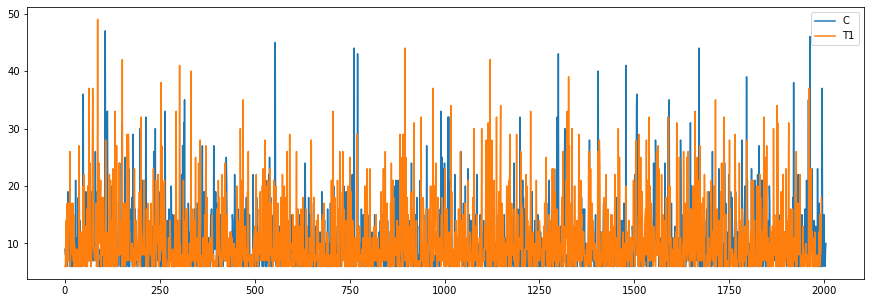

In [321]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["tracks"], label=treatment)
ax.legend()
pass

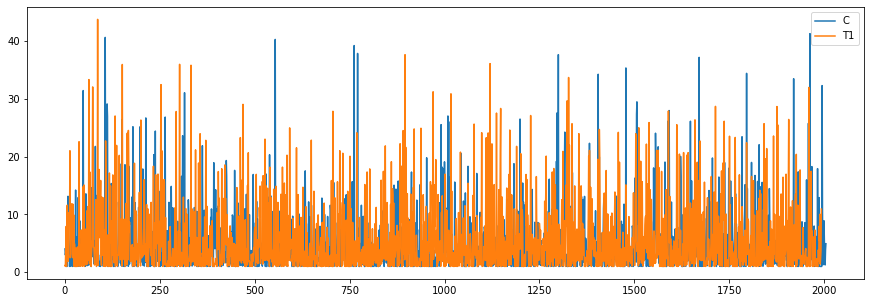

In [322]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["time"], label=treatment)
ax.legend()
pass

## Analyze the experiment

In [323]:
user_level_data = (
  sessions
    .reset_index()
    .groupby(["user", "treatment"])
    .agg(
        {
            "timestamp": "count",
            "tracks": "sum",
            "time": "sum",
            "latency": "sum"
        }
    )
)

user_level_data["sessions"] = user_level_data["timestamp"]
user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

metrics = [
    "time", 
    "sessions", 
    "mean_request_latency", 
    "mean_tracks_per_session", 
    "mean_time_per_session"
]

user_level_metrics = user_level_data[metrics].copy().reset_index()

In [324]:
treatment_level_metrics = (
    user_level_metrics
    .groupby("treatment")[metrics]
    .agg(["count", "mean", "var"])
)

In [325]:
def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)


effects = []

control = [data for treatment, data in treatment_level_metrics.iterrows() if treatment == "C"][0]

for treatment, row in treatment_level_metrics.iterrows():
    if treatment == "C":
        continue
    
    for metric in metrics:
        control_mean = control[metric]["mean"]
        treatment_mean = row[metric]["mean"]
        
        effect = treatment_mean - control_mean
        conf_int = ci(
            control[metric]["count"],
            row[metric]["count"],
            control[metric]["var"],
            row[metric]["var"],
        )
        effects.append({
            "treatment": treatment,
            "metric": metric,
            "control_mean": control_mean,
            "treatment_mean": treatment_mean,
            "effect": effect / control_mean * 100,
            "lower": (effect - conf_int) / control_mean * 100,
            "upper": (effect + conf_int) / control_mean * 100,
            "significant": (effect + conf_int) * (effect - conf_int) > 0
        })

In [326]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

results_contextual_comp_final = (
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)
results_contextual_comp_final

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,19.267855,27.638324,10.897386,5.789994,6.905602,True
1,T1,sessions,2.073559,4.765877,-0.618758,1.193337,1.218082,False
3,T1,mean_tracks_per_session,8.175088,12.100613,4.249563,9.886129,10.694329,True
4,T1,mean_time_per_session,16.068601,23.852156,8.285046,4.884841,5.669767,True
2,T1,mean_request_latency,-3.462325,-1.874234,-5.050416,0.409682,0.395498,True


In [327]:
results_contextual_final

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
10,T3,time,13.431829,25.221095,1.642563,5.850649,6.636498,True
5,T2,time,15.403169,26.784673,4.021664,5.850649,6.751834,True
0,T1,time,14.088400,25.229563,2.947237,5.850649,6.674912,True
11,T3,sessions,-0.569469,3.301928,-4.440865,1.221154,1.214200,False
6,T2,sessions,-1.315011,2.413420,-5.043441,1.221154,1.205096,False
1,T1,sessions,-0.981707,2.791496,-4.754911,1.221154,1.209166,False
13,T3,mean_tracks_per_session,6.493867,12.107629,0.880104,9.867388,10.508163,True
8,T2,mean_tracks_per_session,7.129801,12.584636,1.674966,9.867388,10.570913,True
3,T1,mean_tracks_per_session,6.194798,11.447175,0.942421,9.867388,10.478653,True
14,T3,mean_time_per_session,12.043964,23.152301,0.935626,4.882857,5.470946,True


In [328]:
results_contextual_vs_custom

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
15,T4,time,0.706543,12.496205,-11.083119,5.623926,5.663661,False
10,T3,time,9.095905,21.990685,-3.798876,5.623926,6.135473,False
5,T2,time,5.508894,17.764163,-6.746375,5.623926,5.933742,False
0,T1,time,21.089525,34.552758,7.626292,5.623926,6.809985,True
16,T4,sessions,0.928650,5.008531,-3.151230,1.204444,1.215630,False
11,T3,sessions,-0.497726,3.534513,-4.529965,1.204444,1.198450,False
6,T2,sessions,0.609326,4.749107,-3.530455,1.204444,1.211783,False
1,T1,sessions,-0.147929,3.809788,-4.105646,1.204444,1.202663,False
18,T4,mean_tracks_per_session,-0.252584,5.352475,-5.857642,9.721975,9.697419,False
13,T3,mean_tracks_per_session,3.456448,9.332360,-2.419464,9.721975,10.058010,False
